In [1]:
import numpy as np
import pandas as pd
import gensim
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

/opt/software/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2025-03-30 22:25:08.796691: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from tensorflow import keras
from keras.preprocessing import image, sequence, text # Import necessary submodules

## *Get the data*

In [4]:
data = pd.read_csv("cleaned_hm.csv")
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


## *Basic data cleaning*

In [5]:
data["predicted_category"].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [6]:
data["num_sentence"].value_counts()

1     83711
2      9542
3      3847
4      1624
5       821
6       336
7       183
8       107
10       68
9        61
11       35
13       26
12       21
16       17
18       17
14       14
17       14
19       12
21       10
15        7
23        7
25        7
26        5
24        5
22        4
30        3
31        3
20        3
29        3
27        2
32        2
40        2
37        2
69        1
60        1
34        1
42        1
44        1
48        1
35        1
46        1
51        1
56        1
53        1
58        1
28        1
45        1
Name: num_sentence, dtype: int64

In [7]:
# deleting happy moments with more than 10 sentences
mod_data = data.loc[data['num_sentence'] <= 10]
mod_data["predicted_category"].value_counts()

affection           34020
achievement         33966
enjoy_the_moment    11115
bonding             10700
leisure              7458
nature               1839
exercise             1202
Name: predicted_category, dtype: int64

In [8]:
## categorical to numerical
encode = {
    "affection" : 0,
    "achievement"  : 1,       
    "bonding" : 2,    
    "enjoy_the_moment" : 3,     
    "leisure"  : 4,    
    "nature" : 5,    
    "exercise" : 6
}

In [9]:
mod_data["predicted_category"] = mod_data["predicted_category"].apply(lambda x: encode[x])
mod_data.head()

/tmp/ipykernel_2256335/862238804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_data["predicted_category"] = mod_data["predicted_category"].apply(lambda x: encode[x])


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,0
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,0
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,6
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,2
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,0


## *Data cleaning for NLP*

In [10]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

happy_lines = list()
lines = mod_data["cleaned_hm"].values.tolist()

for line in lines:
    # tokenize the text
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    # remove puntuations
    # Create translation table to remove punctuation

    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # string.punctuation contains all ASCII punctuation characters.
    # str.maketrans('', '', string.punctuation) creates a translation table where each
    # punctuation character is mapped to None, effectively removing them.
    # w.translate(table) applies the translation table to each string w in the list tokens.
    # The list comprehension [w.translate(table) for w in tokens] creates a new list (stripped)
    # where each string in the original tokens list has its punctuation removed.
    # This code is useful when you want to preprocess text data by removing punctuation, which is a 
    # common step in natural language processing tasks.
    # remove non alphabetic characters
    words = [word for word in stripped if word.isalpha()]
    happy_lines.append(words)
    
happy_lines[0:5]

[['i',
  'went',
  'on',
  'a',
  'successful',
  'date',
  'with',
  'someone',
  'i',
  'felt',
  'sympathy',
  'and',
  'connection',
  'with'],
 ['i',
  'was',
  'happy',
  'when',
  'my',
  'son',
  'got',
  'marks',
  'in',
  'his',
  'examination'],
 ['i', 'went', 'to', 'the', 'gym', 'this', 'morning', 'and', 'did', 'yoga'],
 ['we',
  'had',
  'a',
  'serious',
  'talk',
  'with',
  'some',
  'friends',
  'of',
  'ours',
  'who',
  'have',
  'been',
  'flaky',
  'lately',
  'they',
  'understood',
  'and',
  'we',
  'had',
  'a',
  'good',
  'evening',
  'hanging',
  'out'],
 ['i',
  'went',
  'with',
  'grandchildren',
  'to',
  'butterfly',
  'display',
  'at',
  'crohn',
  'conservatory']]

# Example for clarification

In [36]:
Sample_String = '''I am planning another trip upcoming in @August. This one is a week-long trip in %Colorado. Planning makes me so excited. I love seeing everything coming together and falling into place. I will probably continue to be happy about this randomly up to the point of the actual trip.'''

In [37]:
print(Sample_String)

I am planning another trip upcoming in @August. This one is a week-long trip in %Colorado. Planning makes me so excited. I love seeing everything coming together and falling into place. I will probably continue to be happy about this randomly up to the point of the actual trip.


In [39]:
tokens_check = word_tokenize(Sample_String)
tokens_check

['I',
 'am',
 'planning',
 'another',
 'trip',
 'upcoming',
 'in',
 '@',
 'August',
 '.',
 'This',
 'one',
 'is',
 'a',
 'week-long',
 'trip',
 'in',
 '%',
 'Colorado',
 '.',
 'Planning',
 'makes',
 'me',
 'so',
 'excited',
 '.',
 'I',
 'love',
 'seeing',
 'everything',
 'coming',
 'together',
 'and',
 'falling',
 'into',
 'place',
 '.',
 'I',
 'will',
 'probably',
 'continue',
 'to',
 'be',
 'happy',
 'about',
 'this',
 'randomly',
 'up',
 'to',
 'the',
 'point',
 'of',
 'the',
 'actual',
 'trip',
 '.']

In [40]:
tokens_change_to_lower_case_check = [w.lower() for w in tokens_check]

In [41]:
tokens_change_to_lower_case_check

['i',
 'am',
 'planning',
 'another',
 'trip',
 'upcoming',
 'in',
 '@',
 'august',
 '.',
 'this',
 'one',
 'is',
 'a',
 'week-long',
 'trip',
 'in',
 '%',
 'colorado',
 '.',
 'planning',
 'makes',
 'me',
 'so',
 'excited',
 '.',
 'i',
 'love',
 'seeing',
 'everything',
 'coming',
 'together',
 'and',
 'falling',
 'into',
 'place',
 '.',
 'i',
 'will',
 'probably',
 'continue',
 'to',
 'be',
 'happy',
 'about',
 'this',
 'randomly',
 'up',
 'to',
 'the',
 'point',
 'of',
 'the',
 'actual',
 'trip',
 '.']

In [43]:
table = str.maketrans('', '', string.punctuation)
table

{33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None}

In [44]:
stripped_after_changing_to_lower_case_check = [w.translate(table) for w in tokens_change_to_lower_case_check]

In [45]:
stripped_after_changing_to_lower_case_check

['i',
 'am',
 'planning',
 'another',
 'trip',
 'upcoming',
 'in',
 '',
 'august',
 '',
 'this',
 'one',
 'is',
 'a',
 'weeklong',
 'trip',
 'in',
 '',
 'colorado',
 '',
 'planning',
 'makes',
 'me',
 'so',
 'excited',
 '',
 'i',
 'love',
 'seeing',
 'everything',
 'coming',
 'together',
 'and',
 'falling',
 'into',
 'place',
 '',
 'i',
 'will',
 'probably',
 'continue',
 'to',
 'be',
 'happy',
 'about',
 'this',
 'randomly',
 'up',
 'to',
 'the',
 'point',
 'of',
 'the',
 'actual',
 'trip',
 '']

In [46]:
consider_words_only = [word for word in stripped_after_changing_to_lower_case_check if word.isalpha()]

In [47]:
consider_words_only

['i',
 'am',
 'planning',
 'another',
 'trip',
 'upcoming',
 'in',
 'august',
 'this',
 'one',
 'is',
 'a',
 'weeklong',
 'trip',
 'in',
 'colorado',
 'planning',
 'makes',
 'me',
 'so',
 'excited',
 'i',
 'love',
 'seeing',
 'everything',
 'coming',
 'together',
 'and',
 'falling',
 'into',
 'place',
 'i',
 'will',
 'probably',
 'continue',
 'to',
 'be',
 'happy',
 'about',
 'this',
 'randomly',
 'up',
 'to',
 'the',
 'point',
 'of',
 'the',
 'actual',
 'trip']

## *Train-test split*

In [11]:
validation_split = 0.2
max_length = 55

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences = tokenizer_obj.texts_to_sequences(happy_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  mod_data['predicted_category'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

unique tokens - 26138
vocab_size - 26139


In [12]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (80240, 55)
Shape of y_train: (80240, 7)
Shape of X_test_pad: (20060, 55)
Shape of y_test: (20060, 7)


In [13]:
X_train_pad

array([[   2,  438,   82, ...,    0,    0,    0],
       [   1,    7,   16, ...,    0,    0,    0],
       [   1,   23,    4, ...,    0,    0,    0],
       ...,
       [3526,  291,  297, ...,    9,  641,  573],
       [ 245,    1,   35, ...,    0,    0,    0],
       [ 323,    3,  176, ...,    0,    0,    0]], dtype=int32)

## *Custom word2vec model*

In [14]:
import gensim
model = gensim.models.Word2Vec(sentences=happy_lines, vector_size=100, window=5, workers=4, min_count=1, sg=0) #sg= 1:skip-gram 0:cbow

# Get the vocabulary words using key_to_index
vocab_words = list(model.wv.key_to_index)

# Print the number of vocabulary words
print(len(vocab_words))

26138


In [15]:
filename = "happydb_word2vec_full.txt"
model.wv.save_word2vec_format(filename, binary=False)

# Reading word embeddings from a file and creating a dictionary (embedding_index) where each word is associated with its corresponding vector.

In [16]:
embedding_index = {}
f = open(os.path.join('', 'happydb_word2vec_full.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [50]:
len(embedding_index)

26139

In [49]:
embedding_index.get('happy')

array([-0.36141628,  2.222658  , -0.08407358, -1.1473291 ,  0.50822854,
       -1.4953653 , -1.9066303 ,  0.6842369 ,  2.38822   , -0.08272869,
        2.1304731 ,  0.9810676 , -1.6847763 , -2.6086364 , -0.6836368 ,
        0.5094066 ,  2.2954648 , -1.2624501 , -0.39568564, -0.4269277 ,
        0.41840097,  1.9915693 , -1.5120773 , -0.21774986, -0.2174375 ,
        0.40172452,  2.1200924 , -2.6018448 ,  0.39258412,  0.4720535 ,
       -1.1347656 ,  1.5155182 ,  0.93384683, -1.8052429 , -2.7265024 ,
       -3.9816885 ,  2.06306   ,  1.9569118 ,  1.8432055 ,  1.8462367 ,
        0.08424091, -0.55800074,  0.17953326,  0.01444936,  0.18148655,
        1.6378179 , -0.75148565, -0.751558  , -2.6604967 ,  2.819138  ,
        1.6155024 ,  2.2401052 ,  1.7304711 , -2.5005307 , -3.0627136 ,
        0.58920574,  1.6415236 ,  0.016951  , -0.80626076,  2.5665596 ,
       -3.1788633 , -0.6848372 , -1.2000588 ,  0.88756794,  0.8996949 ,
        1.8741596 , -0.30173773, -1.4208113 , -0.34396186, -1.14

In [51]:
embedding_index.get('enjoy')

array([ 0.20283154, -0.5232191 ,  0.72504485, -0.90172654,  1.3296161 ,
        0.67790073, -0.95328045, -1.6677502 ,  0.09292262, -0.31312963,
        2.036777  , -0.304501  , -0.24740037,  0.1395049 ,  0.09924062,
       -0.25786072,  0.9660615 , -0.7141771 ,  0.44967926,  0.63643557,
        1.0437442 , -0.31435212,  0.14476153,  1.3354836 , -0.7279336 ,
        0.59569854, -0.24310692, -0.8632887 ,  2.3329086 , -0.43159896,
       -0.324608  ,  1.7451137 ,  1.4263622 , -0.91875094,  1.3832802 ,
        0.13514334, -0.10518683, -0.41244498, -1.6287626 , -0.76917905,
       -0.5692644 , -2.8127568 ,  1.9945592 ,  1.0059414 ,  1.241983  ,
        0.39819577, -1.6814232 ,  1.1383121 , -1.1060469 , -1.5251166 ,
        1.2326659 , -0.2785382 , -0.2720367 ,  1.406429  , -1.9208878 ,
       -0.33737677, -0.7533319 , -0.6316647 ,  1.1968518 ,  0.78525484,
       -0.5341978 , -1.4371673 ,  1.4509171 ,  0.66044533,  0.5714416 ,
        1.1949854 , -1.0545905 , -0.82904196, -1.0034882 ,  0.51

In [54]:
embedding_index.get('colorado')

array([-0.0706754 ,  0.03077089, -0.10658567, -0.05469365,  0.12463199,
       -0.23055337,  0.12254044,  0.4315224 , -0.02150998, -0.03514884,
       -0.31198975, -0.3220141 , -0.09269856, -0.01451761,  0.05266067,
       -0.15377694, -0.09516769, -0.14665124, -0.25116608, -0.1852504 ,
        0.01345414, -0.13633424,  0.02668265,  0.01972168, -0.0867837 ,
       -0.14701362, -0.04589313, -0.29161263, -0.30121988,  0.12139988,
        0.1509182 , -0.17633796,  0.26589033, -0.18722613,  0.00642862,
        0.2375209 ,  0.05584031,  0.06256469, -0.05568959, -0.25393137,
        0.14330968, -0.30068958, -0.17904076, -0.13363957,  0.22836217,
       -0.16012837, -0.06087362,  0.04550441, -0.09518021, -0.0369053 ,
        0.21282902, -0.26665747,  0.01323566, -0.17953596, -0.02919656,
        0.28655586,  0.23747836,  0.11371733, -0.03098153,  0.13543504,
        0.09880634, -0.03472791,  0.1334418 , -0.33608586, -0.06943272,
       -0.02445525, -0.05106779,  0.1660789 , -0.3014238 ,  0.25

# Creating an embedding matrix using pre-trained word embeddings (loaded into embedding_index) for words in a given vocabulary (word_index). The embedding matrix is often used as the initial weights for an embedding layer in a neural network.

In [17]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# embedding_dim = 100

# max_length = 55

# When trainable is set to False in the context of the Embedding layer in a neural network, it means that the weights of the embedding layer should remain fixed and not be updated during the training process. In other words, the pre-trained word embeddings that you initialized the layer with (embedding_matrix in your case) will not be fine-tuned based on the specific task or dataset on which the model is being trained.

In [18]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [19]:
# define model
model_own = Sequential()
model_own.add(embedding_layer)
model_own.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_own.add(Dense(7, activation='softmax'))

model_own.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_own.summary())

2025-03-30 22:25:31.738433: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-03-30 22:25:31.747198: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2027] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-03-30 22:25:32.928827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22278 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 100)           2613900   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 2,631,155
Trainable params: 17,255
Non-trainable params: 2,613,900
_________________________________________________________________
None


In [20]:
X_train_pad.shape

(80240, 55)

In [21]:
X_train_pad

array([[   2,  438,   82, ...,    0,    0,    0],
       [   1,    7,   16, ...,    0,    0,    0],
       [   1,   23,    4, ...,    0,    0,    0],
       ...,
       [3526,  291,  297, ...,    9,  641,  573],
       [ 245,    1,   35, ...,    0,    0,    0],
       [ 323,    3,  176, ...,    0,    0,    0]], dtype=int32)

In [22]:
y_train.shape

(80240, 7)

In [23]:
X_test_pad.shape

(20060, 55)

In [24]:
y_test.shape

(20060, 7)

In [25]:
history = model_own.fit(X_train_pad, y_train, batch_size=32, epochs=15, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/15


2025-03-30 22:25:36.928674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2508/2508 [==============================] - 212s 83ms/step - loss: 1.1756 - accuracy: 0.5495 - val_loss: 0.7732 - val_accuracy: 0.7204
Epoch 2/15
2508/2508 [==============================] - 207s 83ms/step - loss: 0.6178 - accuracy: 0.7995 - val_loss: 0.4918 - val_accuracy: 0.8337
Epoch 3/15
2508/2508 [==============================] - 205s 82ms/step - loss: 0.4903 - accuracy: 0.8317 - val_loss: 0.4154 - val_accuracy: 0.8528
Epoch 4/15
2508/2508 [==============================] - 205s 82ms/step - loss: 0.4303 - accuracy: 0.8470 - val_loss: 0.3821 - val_accuracy: 0.8620
Epoch 5/15
2508/2508 [==============================] - 205s 82ms/step - loss: 0.3991 - accuracy: 0.8567 - val_loss: 0.3799 - val_accuracy: 0.8655
Epoch 6/15
2508/2508 [==============================] - 205s 82ms/step - loss: 0.3836 - accuracy: 0.8614 - val_loss: 0.3518 - val_accuracy: 0.8706
Epoch 7/15
2508/2508 [==============================] - 205s 82ms/step - loss: 0.3729 - accuracy: 0.8654 - val_loss: 0.3505 - val

In [31]:
model_own.save('trained_model_with_custom_word2vec_with_lstom_on_cleaned_hm_dataset.h5')

In [29]:
%matplotlib inline

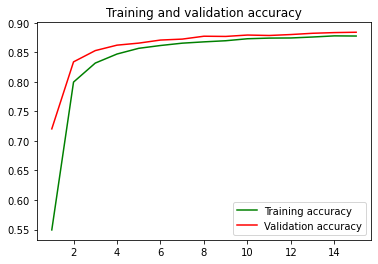

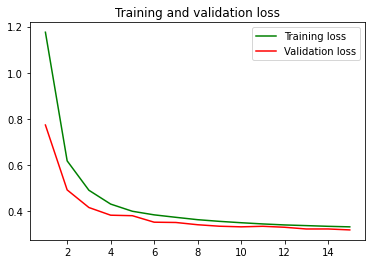

In [30]:
# Plot results5
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Sanity Check

In [180]:
String_to_check_what_kind_of_category_is_it = '''Last month my Uncle and Aunty had visited my house after 3 years. They took me around many places and we went shopping. They took care of me every moment they were with me. They have always been very close to me all these years of my life. Those are memorable moments.'''

In [181]:
test_tokens = word_tokenize(String_to_check_what_kind_of_category_is_it)
test_tokens = [w.lower() for w in test_tokens]
table = str.maketrans('', '', string.punctuation)
stripped_test_dataset = [w.translate(table) for w in test_tokens]
test_words = [word for word in stripped_test_dataset if word.isalpha()]

In [182]:
test_words_truncated_or_padded_dependent_on_the_data = tokenizer_obj.texts_to_sequences(test_words)
flattened_test_words_truncated_or_padded_dependent_on_the_data = np.array(test_words_truncated_or_padded_dependent_on_the_data).flatten()

In [183]:
len(flattened_test_words_truncated_or_padded_dependent_on_the_data)

51

In [184]:
flattened_test_words_truncated_or_padded_dependent_on_the_data.shape

(51,)

In [185]:
one_question_array = np.array(flattened_test_words_truncated_or_padded_dependent_on_the_data).reshape(1, -1)

In [186]:
one_question_array.shape

(1, 51)

In [187]:
test_words_truncated_or_padded_dependent_on_the_data_only_first_55_tokens = pad_sequences(one_question_array, maxlen=max_length, padding='post')

In [188]:
test_words_truncated_or_padded_dependent_on_the_data_only_first_55_tokens.shape

(1, 55)

In [189]:
test_words_truncated_or_padded_dependent_on_the_data_only_first_55_tokens

array([[  38,  102,    2,  438,    5, 4342,   18,  349,    2,  117,   43,
         131,   80,  107,   10,  199,  214,  997,    5,   21,   23,  243,
          80,  107,  461,   11,   10,  294,   87,   80,   90,   13,   10,
          80,   35,  257,   53,   26,  379,    4,   10,   51,  499,  131,
          11,    2,   89,  534,   93,  801,  427,    0,    0,    0,    0]],
      dtype=int32)

In [190]:
model_own = load_model('trained_model_with_custom_word2vec_with_lstom_on_cleaned_hm_dataset.h5')

In [191]:
prediction = model_own.predict(test_words_truncated_or_padded_dependent_on_the_data_only_first_55_tokens)

1/1 [==============================] - 0s 210ms/step


In [192]:
flatten_prediction = prediction.flatten()

In [193]:
flatten_prediction

array([9.7158235e-01, 3.9991424e-03, 6.7470381e-03, 1.6534392e-02,
       3.8647919e-04, 6.6049822e-04, 9.0155379e-05], dtype=float32)

In [194]:
## categorical to numerical
encode = {
    "affection" : 0,
    "achievement"  : 1,       
    "bonding" : 2,    
    "enjoy_the_moment" : 3,     
    "leisure"  : 4,    
    "nature" : 5,    
    "exercise" : 6
}

reverse_encode = {v: k for k, v in encode.items()}

In [195]:
reverse_encode.get(np.argmax(flatten_prediction))

'affection'

# Example 1: My wife gave birth to a baby boy and this made me happy.
# Example 2: I went to do some exams at the ophthalmologist to see how I followed my vision, after the operation, everything was perfect until the times.
# Example 3: Last month my Uncle and Aunty had visited my house after 3 years. They took me around many places and we went shopping. They took care of me every moment they were with me. They have always been very close to me all these years of my life. Those are memorable moments.

# Thank You